In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qa-vlm-med/VQA_dataset.csv
/kaggle/input/qa-vlm-med/VQA_med.json
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/8c34821a-9c15-4a3a-b9e2-c602bc4edac2.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/b7ddc906-dab5-47ef-b0e9-a587432f92e0.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/c085b861-e084-4bea-8d2c-c07136a6ab99.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/1583cf18-3838-40f3-8342-3eb229af65d6.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/afeb922d-5b50-4cc7-80dd-782bb3b44810.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/f08b113c-da3d-4da4-977e-db1022b7dc6a.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/021cfd76-552a-4b00-ad76-9968ce5497f9.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/8aaf5905-f6ff-4743-a639-752fba0dd2e4.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/77d8eef1-119a-48f6-9f15-145506b90da7.jpg
/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/c2846151-4c7c-4334-b3fa-692248c6c46b.jpg
/kaggle/inp

In [29]:
pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


# **Dataset Overview**

This dataset contains a diverse collection of medical images spanning multiple domains, including : **radiology, pathology, dermatology, and ophthalmology**.

Each image is accompanied by a set of structured question-and-answer pairs designed to enhance medical AI applications, such as automated diagnosis, visual question answering (VQA), and decision support systems.

# **Dataset Features**

**Medical Domains:** Covers various specialties such as :
* X-rays
* MRIs
* CT scans
* Histopathology slides
* Skin lesion images
* Retinal scans

**Annotated Q&A Pairs:** Each image includes multiple  medically relevant questions and their corresponding expert-verified answers.

**Metadata:** Images are labeled with key attributes such as : **modality, anatomical region, disease condition, and clinical findings**.

***-High-Quality Annotations: Curated from medical experts to ensure reliability and accuracy.***

# Uploading Libraries

In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

# EDA

In [31]:
df = pd.read_csv("/kaggle/input/qa-vlm-med/VQA_dataset.csv")
print(df.head())

   Unnamed: 0                                    id  \
0           0  a0bc6b74-1f8a-43c7-890a-188e26f7e029   
1           1  a0bc6b74-1f8a-43c7-890a-188e26f7e029   
2           2  a0bc6b74-1f8a-43c7-890a-188e26f7e029   
3           3  a0bc6b74-1f8a-43c7-890a-188e26f7e029   
4           4  a0bc6b74-1f8a-43c7-890a-188e26f7e029   

                                      image  \
0  a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg   
1  a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg   
2  a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg   
3  a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg   
4  a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg   

                                           Questions  \
0           What does the CT angiography image show?   
1         What does the arrow in the image indicate?   
2             What is sequestration in this context?   
3  How can anomalous arterial supply affect the l...   
4  What treatment options are available for this ...   

                                             Answ

In [32]:
df = df[["image", "Questions", "Answers"]]

In [33]:
df.head(10)

,image,Questions,Answers
0,a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg,What does the CT angiography image show?,The CT angiography image shows an anomalous ar...
1,a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg,What does the arrow in the image indicate?,The arrow points to the anomalous arterial sup...
2,a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg,What is sequestration in this context?,Sequestration refers to a congenital condition...
3,a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg,How can anomalous arterial supply affect the l...,Anomalous arterial supply can lead to improper...
4,a0bc6b74-1f8a-43c7-890a-188e26f7e029.jpg,What treatment options are available for this ...,Treatment options for this condition may inclu...
5,f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg,What is the sex of the patient in the image?,The patient in the image is female.
6,f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg,Can you tell me the approximate age of the pat...,The approximate age of the patient in the imag...
7,f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg,Where is the imaged site located on the patient?,The imaged site is located on the torso of the...
8,f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg,What is the diagnosis of the lesion in the image?,The diagnosis of the lesion in the image is ne...
9,f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg,Is the imaged lesion benign or malignant?,The imaged lesion is benign.


In [34]:
df.shape

(16536, 3)

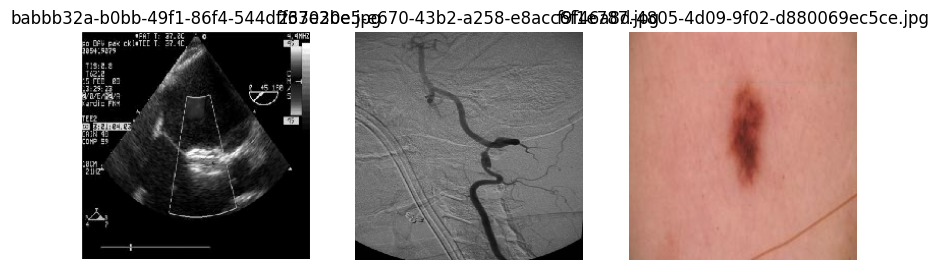

In [35]:
# Sélectionner 3 images aléatoires
import random

sample_images = random.sample(list(df["image"]), 3)

plt.figure(figsize=(10,4))

for i, img_name in enumerate(sample_images):
    # Charger et prétraiter l'image
    img_path = f"/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/{img_name}"
    img = load_img(img_path, target_size=(224,224))
    img_array = img_to_array(img)/255.0

    # Afficher
    plt.subplot(1,3,i+1)
    plt.imshow(img_array)
    plt.title(img_name)
    plt.axis('off')

plt.show()

# Checking classes and Answers distribution

In [36]:
# Encodage labels (réponses)
label_encoder = LabelEncoder()
df["answer_encoded"] = label_encoder.fit_transform(df["Answers"])
num_classes = len(label_encoder.classes_)
print("Number of classes :" ,num_classes)

Number of classes : 12145


From 16536 rows we have 12145 different answer so almost a different answer for each row . this is so huge so we choose to check the most common answers.

In [37]:
from collections import Counter

# Compter fréquence des réponses
freq = Counter(df["Answers"])
common_answers = [ans for ans, c in freq.items() if c >= 70]

# Garder seulement ces réponses
df_filtered = df[df["Answers"].isin(common_answers)]
print("New number of classes:", df_filtered["Answers"].nunique())

New number of classes: 8


In [38]:
# Afficher les classes retenues
classes_freq = df_filtered["Answers"].value_counts()
print("Class distribution :")
print(classes_freq)

for ans in df_filtered["Answers"].unique():
    print(f"\n=== Answer : {ans} ===")
    questions = df_filtered[df_filtered["Answers"] == ans]["Questions"].unique()  # unique() supprime les doublons
    for q in questions[:10]:  # limite à 10 questions distinctes
        print("-", q)

Class distribution :
Answers
The imaged lesion is benign.                               289
The lesion is benign.                                      136
Yes, the lesion is melanocytic.                            104
The imaged site is located on the torso of the patient.     99
The lesion in the image is benign.                          94
The patient in the image is female.                         86
The patient in the image is male.                           76
The diagnosis of the imaged lesion is unknown.              70
Name: count, dtype: int64

=== Answer : The patient in the image is female. ===
- What is the sex of the patient in the image?
- What is the sex of the patient in the provided image?
- Can you tell me the sex of the patient in the image?
- Can you provide the sex of the patient in the image?
- Can you tell me the sex of the patient in this image?
- What is the sex of the patient based on the image?
- What is the sex of the patient in the image provided?

=== Answ

We noticed that we have 8 classes so similar that basically there are 4 answers with different words (but the same meaning) , the same for the questions .. So we need normalization to find the real classes without redondance.

# Data Preprocessing

In [39]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering

# Answers Normalization

In [40]:
all_answers = df["Answers"].unique()

model_sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
answer_embeddings = model_sbert.encode(all_answers, convert_to_tensor=True)

clustering_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,  # ajuster selon besoin
    affinity='cosine',
    linkage='average'
)
clusters = clustering_model.fit_predict(answer_embeddings.cpu().numpy())

cluster_map = {}
for cluster_id, answer in zip(clusters, all_answers):
    cluster_map.setdefault(cluster_id, []).append(answer)

# Choisir une réponse représentative
normalized_answers = {ans: cluster_map[cluster_id][0]
                      for cluster_id, answers in cluster_map.items()
                      for ans in answers}

# Appliquer la normalisation
df["Normalized_Answer"] = df["Answers"].map(normalized_answers)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [41]:
print("Nombre original de classes :", len(df["Answers"].unique()))
print("Nombre de classes après normalisation :", len(df["Normalized_Answer"].unique()))

Nombre original de classes : 12145
Nombre de classes après normalisation : 1575


In [42]:
freq = Counter(df["Normalized_Answer"])
common_answers = [ans for ans, c in freq.items() if c >= 90]

# Garder seulement ces réponses
df_filtered1 = df[df["Normalized_Answer"].isin(common_answers)]
print("New number of classes:", df_filtered1["Normalized_Answer"].nunique())

New number of classes: 12


# Checking similarity of 2 questions from the same cluster

Here i checked the results previously and i found that we have 34 questions divided into 4 clusters .

In [43]:

q1 = "What is the sex of the patient in the provided image?"
q2 = "Can you provide the sex of the patient in the image?"

embedding1 = model.encode(q1, convert_to_tensor=True)
embedding2 = model.encode(q2, convert_to_tensor=True)
similarity = util.pytorch_cos_sim(embedding1, embedding2)
print(f"Similarity: {similarity.item():.4f}")


Similarity: 0.9081


The similarity between 2 questions from the same cluster is 0.91 . The questions are almost the same.

# Questions Normalization

In [44]:
normalized_questions = {qid: cluster_map[cluster_id][0]
                        for cluster_id, questions in cluster_map.items()
                        for qid in questions}

df_filtered1["Normalized_Question"] = df["Questions"].map(normalized_questions)

In [45]:
all_questions = df["Questions"].unique()

# Encode using Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
question_embeddings = model.encode(all_questions, convert_to_tensor=True)

# Cluster similar questions
clustering_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.4,  # plus strict
    affinity='cosine',
    linkage='average'
)
clusters = clustering_model.fit_predict(question_embeddings.cpu().numpy())

# Create a mapping: cluster_id → list of questions
cluster_map = {}
for cluster_id, question in zip(clusters, all_questions):
    cluster_map.setdefault(cluster_id, []).append(question)

# Choose a representative question per cluster
normalized_questions = {}
for cluster_id, questions in cluster_map.items():
    normalized_questions[cluster_id] = questions[0]  # first question as representative

# Map each question to its normalized form
question_to_normalized = {}
for cluster_id, questions in cluster_map.items():
    for q in questions:
        question_to_normalized[q] = normalized_questions[cluster_id]

# Apply mapping to dataset
df_filtered1["Normalized_Question"] = df["Questions"].map(question_to_normalized)

# Check result
print(df_filtered1[["Questions", "Normalized_Question"]].head(10))

                                            Questions  \
5        What is the sex of the patient in the image?   
6   Can you tell me the approximate age of the pat...   
7    Where is the imaged site located on the patient?   
8   What is the diagnosis of the lesion in the image?   
9           Is the imaged lesion benign or malignant?   
10        Can you describe what you see in the image?   
11                What is your analysis of the image?   
20           What is the clinical size of the lesion?   
21         Is the skin condition benign or malignant?   
22       What is the diagnosis of the skin condition?   

                                  Normalized_Question  
5        What is the sex of the patient in the image?  
6   Can you tell me the approximate age of the pat...  
7    Where is the imaged site located on the patient?  
8   What is the diagnosis of the lesion in the image?  
9           Is the imaged lesion benign or malignant?  
10        Can you describe what you 

# Modeling

In [76]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 50  # longueur max des questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_filtered1["Normalized_Question"])
X_text = tokenizer.texts_to_sequences(df_filtered1["Normalized_Question"])
X_text = pad_sequences(X_text, maxlen=MAX_LEN)

In [77]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = (128, 128)

def preprocess_image(path):
    img = load_img(f"/kaggle/input/qa-vlm-med/QA_VLM_MED/images/images/{path}", target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    return img

X_images = np.array([preprocess_image(img) for img in df_filtered1["image"]])

In [78]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_filtered1["Normalized_Answer"])
num_classes = len(label_encoder.classes_)

In [94]:
from tensorflow.keras import layers, models, Input

# Texte
text_input = Input(shape=(MAX_LEN,))
x_text = layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(text_input)
x_text = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x_text)
x_text = layers.GlobalMaxPooling1D()(x_text)
x_text = layers.Dropout(0.3)(x_text)

# Image
image_input = Input(shape=(128,128,3))
x_img = layers.Conv2D(32, (3,3), activation='relu')(image_input)
x_img = layers.MaxPooling2D((2,2))(x_img)
x_img = layers.Conv2D(64, (3,3), activation='relu')(x_img)
x_img = layers.MaxPooling2D((2,2))(x_img)
x_img = layers.Flatten()(x_img)

# Fusion
x = layers.concatenate([x_text, x_img])
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=[text_input, image_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [95]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [96]:
# Model checkpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [97]:
history = model.fit([X_text, X_images], y, epochs=13, batch_size=32, validation_split=0.2,callbacks=[early_stop, checkpoint])

Epoch 1/13
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.4383 - loss: 1.7768
Epoch 1: val_loss improved from inf to 0.61354, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 70s 349ms/step - accuracy: 0.4392 - loss: 1.7736 - val_accuracy: 0.7970 - val_loss: 0.6135
Epoch 2/13
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7969 - loss: 0.5442
Epoch 2: val_loss improved from 0.61354 to 0.50214, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 66s 347ms/step - accuracy: 0.7970 - loss: 0.5441 - val_accuracy: 0.8167 - val_loss: 0.5021
Epoch 3/13
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8541 - loss: 0.4227
Epoch 3: val_loss improved from 0.50214 to 0.45871, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 66s 343ms/step - accuracy: 0.8541 - loss: 0.4226 - val_accuracy: 0.8397 - val_loss: 0.4587
Epoch 4/13
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8699 - loss: 0.3741
Epoch 4: val_loss did not improve fro

# Results

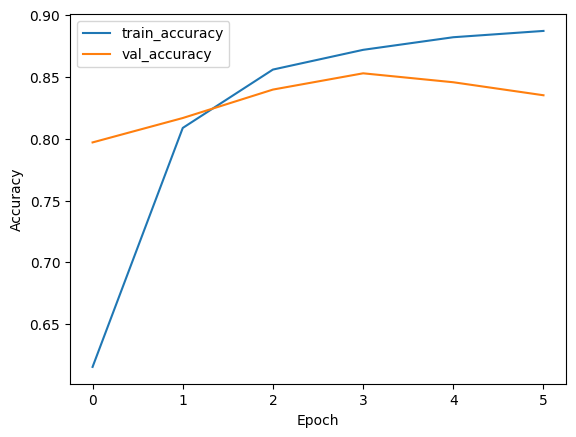

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Question: What is the sex of the patient in the image?
True Answer: The patient in the image is female.
Predicted Answer : The patient in the image is female.


In [98]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


sample_idx = 0
sample_text = X_text[sample_idx:sample_idx+1]
sample_img = X_images[sample_idx:sample_idx+1]
pred_class = np.argmax(model.predict([sample_text, sample_img]))
pred_answer = label_encoder.inverse_transform([pred_class])[0]

print("Question:", df_filtered1.iloc[sample_idx]["Normalized_Question"])
print("True Answer:", df_filtered1.iloc[sample_idx]["Normalized_Answer"])
print("Predicted Answer :", pred_answer)

In [99]:
val_acc_finale = history.history['val_accuracy'][-1]
train_acc_finale = history.history['accuracy'][-1]

print(f"Train Accuracy  : {train_acc_finale:.4f}")
print(f"Validation Accuracy  : {val_acc_finale:.4f}")

Train Accuracy  : 0.8871
Validation Accuracy  : 0.8351


# Total Accuracy

In [100]:
loss, accuracy = model.evaluate([X_text, X_images], y, batch_size=32)
print(f"Total Accuracy over the entire dataset: {accuracy:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8740 - loss: 0.3630
Total Accuracy over the entire dataset: 0.8719


# Save and load the model

In [101]:
model.save("Medical_Answer_Prediction.keras")

In [102]:
from tensorflow.keras.models import load_model

model = load_model("Medical_Answer_Prediction.keras")

# Application

In [105]:
def predict_answer(img_idx=0):
    question = input("Enter your question: ")

    # Encode the question
    seq = tokenizer.texts_to_sequences([question])
    seq = pad_sequences(seq, maxlen=MAX_LEN)

    # Get an existing image from the dataset
    img = X_images[img_idx:img_idx+1]

    # Prediction
    pred_class = np.argmax(model.predict([seq, img]))
    pred_answer = label_encoder.inverse_transform([pred_class])[0]

    # Find the true answer for this exact question & image
    matching_rows = df_filtered1[
        (df_filtered1["Normalized_Question"] == question) &
        (df_filtered1["image"] == df_filtered.iloc[img_idx]["image"])
    ]
    if not matching_rows.empty:
        true_answer = matching_rows.iloc[0]["Normalized_Answer"]
    else:
        true_answer = "No matching true answer found"

    # Display results
    print("\n--- Result ---")
    print("Entered Question       :", question)
    print("Used Image             :", df_filtered1.iloc[img_idx]["image"])
    print("Predicted Answer       :", pred_answer)
    print("True Answer            :", true_answer)
    print("Prediction Correct?    :", pred_answer == true_answer)

predict_answer(img_idx=0)

Enter your question:  Is the imaged lesion benign or malignant?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

--- Result ---
Entered Question       : Is the imaged lesion benign or malignant?
Used Image             : f43821cc-a2fc-4e06-b0ec-0605432edeff.jpg
Predicted Answer       : The imaged lesion is benign.
True Answer            : The imaged lesion is benign.
Prediction Correct?    : True
